# Laboratorio: Deep Learning (seminario)

## Machine Learning tradizionale e Deep Learning

- L'obiettivo generale del _machine learning_ è far sì che un calcolatore **impari tramite esempi** ad eseguire task non esprimibili in forma algoritmica
  - predire variazioni del mercato azionario, capire se un'opinione sia positiva o negativa, riconoscere oggetti in foto e video, ...
- Le tecniche tradizionali si basano sull'estrazione di _feature_ supervisionata dall'utente
  - es. parole dai testi, pattern dalle immagini, ...
  - le feature vanno selezionate attentamente, in modo da "guidare" l'apprendimento così che si basi sulle giuste caratteristiche dei dati
- Nel _deep learning_ vengono addestrati modelli **a molteplici strati**, che rappresentano **diversi livelli d'astrazione** dei dati, forniti al modello in forma "grezza"
- In questo modo anche **la rappresentazione ottimale dei dati è appresa dall'algoritmo**
- Le reti neurali sono usate comunemente come modello di deep learning

## Esempio: Classificazione di Recensioni

- Abbiamo due dataset di recensioni di film estratte da IMDb, classificate come "positive" e "negative"
- Vogliamo addestrare una rete neurale a classificarle sul primo dataset (training) e verificare la sua accuratezza sul secondo (validation)
- Carichiamo i due dataset

In [18]:
import pandas as pd
imdb_train = pd.read_csv("https://bit.ly/2JrF1lk", sep="\t", header=None, names=["label", "text"], compression="gzip")
imdb_val = pd.read_csv("https://bit.ly/2sQnIDb", sep="\t", header=None, names=["label", "text"], compression="gzip")

In [7]:
len(imdb_train), len(imdb_val)

(25000, 25000)

In [8]:
imdb_train.head(4)

,stars,text
0,pos,Bromwell High is a cartoon comedy. It ran at t...
1,neg,Story of a man who has unnatural feelings for ...
2,pos,"If you like adult comedy cartoons, like South ..."
3,neg,Robert DeNiro plays the most unbelievably inte...


In [9]:
imdb_val.head(4)

,stars,text
0,pos,I went and saw this movie last night after bei...
1,neg,Once again Mr. Costner has dragged out a movie...
2,pos,My boyfriend and I went to watch The Guardian....
3,neg,This is a pale imitation of 'Officer and a Gen...


## Keras

- _Keras_ è una libreria di alto livello per la costruzione e l'addestramento di reti neurali
- Permette di costruire facilmente reti neurali, combinando tra loro elementi configurabili
  - strati della rete, funzioni di costo, funzioni d'attivazione, ...
- Utilizza il framework TensorFlow come backend per il calcolo effettivo
  - TensorFlow fornisce supporto per eseguire calcoli accelerati su GPU

## Costruzione Vector Space Model

- Per fornire i testi in ingresso alla rete, rappresentiamoli in uno spazio vettoriale utilizzando i tf.idf come visto in precedenza
  - creiamo lo spazio vettoriale sulle recensioni di training selezionando solo i termini presenti in almeno 3 di esse e lo applichiamo ad entrambi i set

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=3)
dtm_train = vect.fit_transform(imdb_train.text)
dtm_val = vect.transform(imdb_val.text)

- Otteniamo il numero di termini distinti estratti (le dimensioni dello spazio vettoriale), che ci servirà per definire la struttura della rete

In [11]:
num_terms = len(vect.get_feature_names())
num_terms

35853

## Costruire una Rete come Sequenza di Strati

- Il modello `Sequential` di Keras permette di comporre una rete come una sequenza di strati
- Partendo da un modello vuoto...

In [35]:
from keras.models import Sequential
model = Sequential()

- ...possiamo progressivamente aggiungere gli strati che formano la rete

- Lo strato standard è `Dense`, in cui ciascun nodo riceve in input _tutti_ gli output dei nodi allo strato precedente
- Come primo argomento è specificato il numero di nodi in questo strato della rete, poniamo come esempio 4
- Essendo il primo strato della rete, dobbiamo specicare il numero di valori in input ricevuti dall'esterno, che in questo caso è la dimensionalità dello spazio di vettori creato sopra

In [36]:
from keras.layers import Dense
model.add(Dense(16, input_dim=num_terms))

- Otteniamo così uno strato di neuroni ciascuno dei quali da in output una somma pesata dei valori in input

- Su questo strato, possiamo aggiungerne uno di tipo `Activation` che applichi una funzione di attivazione agli output che diventano così non-lineari
- Applichiamo ad esempio la funzione sigmoide, vista anche nella regressione logistica

In [37]:
from keras.layers import Activation
model.add(Activation("sigmoid"))

- In uscita alla rete, vogliamo due nodi che indichino le probabilità per cui una recensione sia positiva o negativa
- Creiamo un altro strato `Dense` con due nodi, ciascuno dei quali riceve in input tutti i 4 valori dello strato precedente con applicata la funzione di attivazione

In [38]:
model.add(Dense(2))

- Per fare in modo che gli output siano delle probabilità la cui somma è 1, applichiamo la funzione di attivazione _softmax_ che le normalizzi

In [39]:
model.add(Activation("softmax"))

- La definizione della rete è così completa

## Compilare una Rete

- Una volta definita la struttura della rete, questa va _compilata_, ovvero va costruito il grafo delle computazioni nel backend TensorFlow
- Per questo si usa il metodo `compile`, a cui vanno indicati
  - la _funzione di costo_ che deve essere minimizzata, nel nostro caso è la _categorical cross entropy_ che misura di quanto le probabilità date dalla rete siano sbagliate
  - l'algoritmo di _ottimizzazione_ usato per minimizzare la funzione di cui sopra, usiamo la _discesa gradiente stocastica_ (SGD)
  - la metrica di valutazione che valuta la qualità effettiva della classificazione: usiamo l'accuratezza (percentuale di recensioni ben classificate)

In [40]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

## Addestrare la Rete

- Per addestrare la rete, come per altri algoritmi, dobbiamo fornire degli esempi di input con i relativi output attesi
- Gli input sono dati dai vettori del VSM già costruito
- Per gli output, convertiamo le etichette in variabili _dummy_ binarie, addestrando quindi la rete a restituire 1 in corrispondenza dell'etichetta giusta e 0 altrimenti

In [41]:
target_train = pd.get_dummies(imdb_train.label)
target_val = pd.get_dummies(imdb_val.label)

- Addestriamo quindi la rete specificando:
  - input e corrispondenti output attesi
  - una _batch size_ che indica quanti esempi considerare ad ogni passo della discesa gradiente
  - un numero di _epoche_ che indica quante iterazioni fare sul training set
- Il metodo `fit` restituisce un resoconto dell'addestramento

In [42]:
fit_history = model.fit(dtm_train, target_train, batch_size=1000, epochs=5)

Epoch 1/5
25000/25000 [==============================] - 10s 396us/step - loss: 0.7101 - acc: 0.5000
Epoch 2/5
25000/25000 [==============================] - 10s 396us/step - loss: 0.6978 - acc: 0.5000
Epoch 3/5
25000/25000 [==============================] - 10s 403us/step - loss: 0.6944 - acc: 0.5000
Epoch 4/5
25000/25000 [==============================] - 10s 397us/step - loss: 0.6935 - acc: 0.5000
Epoch 5/5
25000/25000 [==============================] - 10s 394us/step - loss: 0.6932 - acc: 0.5000


- Possiamo graficare l'andamento della funzione di costo durante le epoche

In [31]:
%matplotlib inline

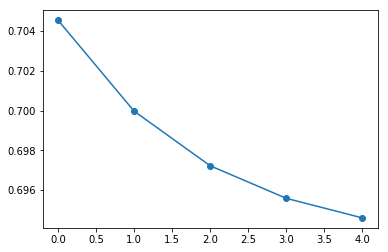

In [33]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history["loss"], "o-")

## Verifica dell'Accuratezza

- Per misurare la metrica di valutazione designata sul validation set, usiamo il metodo `evaluate`

In [34]:
model.evaluate(dtm_val, target_val)

25000/25000 [==============================] - 5s 204us/step


[0.6942182083892823, 0.5]

- Il metodo ci restituisce sia la funzione di costo che l'accuratezza
- In questo caso l'accuratezza non è soddisfacente, vediamo come migliorarla

## Aggiunta di Nodi alla Rete

- Ricreiamo la rete, inserendo più nodi allo strato nascosto ed usando in esso la funzione d'attivazione _Rectified Linear Unit_ (ReLU)
- Possiamo creare un nuovo modello `Sequential` dove questa volta
  - specifichiamo l'elenco di strati direttamente nel costruttore
  - invece di usare strati `Activation`, specifichiamo la funzione d'attivazione direttamente nello strato `Dense`

In [43]:
model = Sequential([
    Dense(64, activation="relu", input_dim=num_terms),
    Dense(2, activation="softmax")
])

- Compiliamo la rete usando l'ottimizzatore "Adam", una versione evoluta della discesa gradiente stocastica
  - viene ad es. applicato un _momento_ per far sì che la direzione della discesa cambi più gradualmente

In [44]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

- Addestriamo la nuova rete

In [45]:
fit_history = model.fit(dtm_train, target_train, batch_size=1000, epochs=5)

Epoch 1/5
25000/25000 [==============================] - 12s 483us/step - loss: 0.6386 - acc: 0.7873
Epoch 2/5
25000/25000 [==============================] - 12s 476us/step - loss: 0.4833 - acc: 0.8821
Epoch 3/5
25000/25000 [==============================] - 12s 476us/step - loss: 0.3512 - acc: 0.9079
Epoch 4/5
25000/25000 [==============================] - 12s 479us/step - loss: 0.2634 - acc: 0.9291
Epoch 5/5
25000/25000 [==============================] - 12s 473us/step - loss: 0.2073 - acc: 0.9451


- Con questi accorgimenti, otteniamo un'accuratezza molto più elevata

In [46]:
model.evaluate(dtm_val, target_val)

25000/25000 [==============================] - 6s 256us/step


[0.3148898386287689, 0.87512]

- Possiamo avere un resoconto della rete col metodo `summary`, che mostra in particolare il numero di singoli parametri da addestrare
  - ad esempio lo strato softmax ha 2 (nodi) * (64 (pesi strato inferiore) + 1 (bias)) = 130 parametri

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                2294656   
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 2,294,786
Trainable params: 2,294,786
Non-trainable params: 0
_________________________________________________________________


## Reti Ricorrenti

- Le _reti ricorrenti_, invece di essere sequenziali, contengono cicli che permettono di mantenere una memoria attraverso più passaggi temporali
- Le _LSTM_ sono un tipo comune di rete ricorrente che utilizzano una struttura particolare per mantenere informazioni in memoria anche a lungo termine
- Possiamo quindi addestrare una rete su _sequenze_ di dati: per le recensioni possiamo quindi considerare ad es. l'ordine delle parole

## Word Embedding

- Un _embedding_ è un modello che associa ad ogni parola di un dizionario un vettore in uno spazio in base alla sua semantica
  - parole simili in significato hanno vettori simili
- Un modello di embedding è addestrato da grandi quantità di testo, da cui si apprendono i contesti tipici di ogni parola
- Possiamo quindi rappresentare un testo come una sequenza di vettori, ciascuno dei quali rappresenta una parola

- Carichiamo un modello embedding preaddestrato con 100.000 parole rappresentate da vettori di misura 100

In [48]:
from urllib.request import urlretrieve
urlretrieve("https://bit.ly/2JkZtZd", "embeddings.gz")

('embeddings.gz', <http.client.HTTPMessage at 0x7f88a6eadbe0>)

In [50]:
import gzip
import numpy as np
embedding_dict = ["(none)"]
embedding = np.empty((100001, 100))
embedding[0] = 0
with gzip.open("embeddings.gz", "rb") as f:
    for i, line in enumerate(f, start=1):
        values = line.split()
        embedding_dict.append(values[0].decode())
        embedding[i] = np.asarray(values[1:], dtype='float32')
embedding_index = pd.Series(np.arange(len(embedding_dict)), index=embedding_dict)

In [51]:
from collections import defaultdict
embedding_index = defaultdict(lambda: 0)
embedding_index.update({w: i for i, w in enumerate(embedding_dict)})

- Scomponiamo le recensioni in sequenze di parole usando NLTK e da esse in sequenze di vettori dell'embedding

In [52]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pasolini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
def text_to_token_nums(texts):
    return [[embedding_index[term] for term in nltk.word_tokenize(text)] for text in texts]
seqs_train = text_to_token_nums(imdb_train.text)
seqs_val = text_to_token_nums(imdb_val.text)

- Per addestrare la rete neurale servono sequenze di dimensioni fisse: eseguiamo il _padding_ per tagliare i testi più lunghi e riempire con vettori vuoti quelli più corti di un numero di parole fissato (quì 100)

In [55]:
max_seq_len = 100
from keras.preprocessing.sequence import pad_sequences
seqmat_train = pad_sequences(seqs_train, maxlen=max_seq_len)
seqmat_val = pad_sequences(seqs_val, maxlen=max_seq_len)

- Creiamo la rete composta da
  - uno strato _embedding_ che traduce le parole in ingresso nei vettori dati dal modello embedding
  - uno strato LSTM con connessioni cicliche che riceve tutta la sequenza di vettori e restituisce i valori di output all'ultimo passaggio
  - uno strato softmax come quello usato sopra che riceve questi valori

In [56]:
from keras.layers import Embedding, LSTM
model = Sequential([
    Embedding(len(embedding_dict), 100, weights=[embedding], input_length=max_seq_len, trainable=False),
    LSTM(16, activation="relu"),
    Dense(2, activation="softmax")
])
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

- Addestriamo la rete

In [57]:
fit_history = model.fit(seqmat_train, target_train, batch_size=1000, epochs=20)

Epoch 1/20
25000/25000 [==============================] - 8s 323us/step - loss: 0.6840 - acc: 0.5535
Epoch 2/20
25000/25000 [==============================] - 8s 310us/step - loss: 0.6581 - acc: 0.6052
Epoch 3/20
25000/25000 [==============================] - 8s 312us/step - loss: 0.6206 - acc: 0.6562
Epoch 4/20
25000/25000 [==============================] - 7s 286us/step - loss: 0.5844 - acc: 0.6913
Epoch 5/20
25000/25000 [==============================] - 7s 287us/step - loss: 0.5599 - acc: 0.7148
Epoch 6/20
25000/25000 [==============================] - 7s 288us/step - loss: 0.5457 - acc: 0.7259
Epoch 7/20
25000/25000 [==============================] - 7s 285us/step - loss: 0.5320 - acc: 0.7386
Epoch 8/20
25000/25000 [==============================] - 7s 293us/step - loss: 0.5239 - acc: 0.7424
Epoch 9/20
25000/25000 [==============================] - 7s 290us/step - loss: 0.5151 - acc: 0.7474
Epoch 10/20
25000/25000 [==============================] - 7s 297us/step - loss: 0.5007 - a

In [58]:
model.evaluate(seqmat_val, target_val)

25000/25000 [==============================] - 10s 417us/step


[0.4762006206321716, 0.77768]